# Attention on MNIST (Saliency and grad-CAM)
from https://github.com/raghakot/keras-vis

In [1]:
from jons_image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Model
from keras.utils import np_utils
from keras import backend as K
import numpy as np

from __future__ import print_function

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

image_size = 200,200
batch_size = 8

C:\Miniconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Apply augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        zoom_range=0.5,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(
        rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    'data/valid',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

test_generator = valid_datagen.flow_from_directory(
    'data/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

num_classes = len(train_generator.class_indices)

Found 348 images belonging to 2 classes.
Found 174 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


In [3]:
nb_train_samples = 348
nb_validation_samples = 174

In [4]:
from keras.regularizers import l2

def wd_model(input_shape, num_classes):
    i= 0.00001 
    '''can choose other values like 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0 -- You would apply 
        higher L2 when the examples are more “different”. So we apply a high one which generally works 
        better for me but also needs more epochs to get to a better result...'''
        
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), input_shape=input_shape, kernel_regularizer=l2(i)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3, 3), kernel_regularizer=l2(i)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3, 3), kernel_regularizer=l2(i)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, kernel_regularizer=l2(i)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=l2(i)))
    model.add(Activation('sigmoid', name='preds'))
    return model

# build the model
model = wd_model(train_generator.image_shape, num_classes)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
# Fit the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=20,
    verbose=1)

Epoch 1/20
43/43 [==============================] - 3s - loss: 0.7102 - acc: 0.5116 - val_loss: 0.6848 - val_acc: 0.4881
Epoch 2/20
43/43 [==============================] - 2s - loss: 0.6964 - acc: 0.6221 - val_loss: 0.6846 - val_acc: 0.6506
Epoch 3/20
43/43 [==============================] - 2s - loss: 0.6540 - acc: 0.6743 - val_loss: 0.6257 - val_acc: 0.6386
Epoch 4/20
43/43 [==============================] - 2s - loss: 0.6096 - acc: 0.6889 - val_loss: 0.5948 - val_acc: 0.6446
Epoch 5/20
43/43 [==============================] - 2s - loss: 0.6071 - acc: 0.6948 - val_loss: 0.6109 - val_acc: 0.6265
Epoch 6/20
43/43 [==============================] - 2s - loss: 0.6179 - acc: 0.6570 - val_loss: 0.6341 - val_acc: 0.6446
Epoch 7/20
43/43 [==============================] - 2s - loss: 0.5617 - acc: 0.7384 - val_loss: 0.6501 - val_acc: 0.6386
Epoch 8/20
43/43 [==============================] - 2s - loss: 0.6210 - acc: 0.7035 - val_loss: 0.6119 - val_acc: 0.6386
Epoch 9/20
43/43 [==============

## Saliency

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.

Lets pick an input over which we want to show the attention.

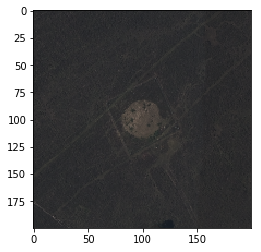

In [6]:
from matplotlib import pyplot as plt
from keras.preprocessing import image

%matplotlib inline
class_idx = 0

# pick some random input from here.
# img_path = '../data/valid/BARROW/BARROW433813-100941.tif'

img_path = 'data/test/BARROW/BARROW439804-104734.tif'
img = image.load_img(img_path, target_size=(200, 200))

# Lets sanity check the picked image.
plt.imshow(img)
img = image.img_to_array(img)

Time for saliency visualization.

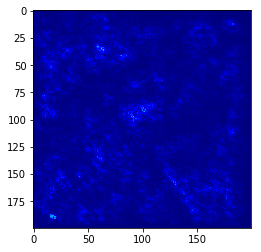

In [7]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
# layer_idx = utils.find_layer_idx(model, 'preds')

layer_idx=14

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=img)
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

To used guided saliency, we need to set `backprop_modifier='guided'`. For rectified saliency or deconv saliency, use `backprop_modifier='relu'`. Lets try these options quickly and see how they compare to vanilla saliency.

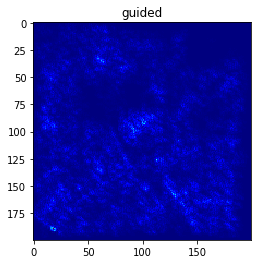

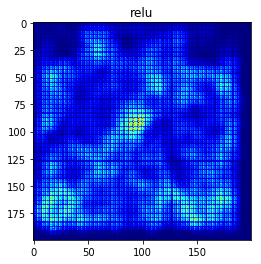

In [8]:
for modifier in ['guided', 'relu']:
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=img, backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')

Both of them look a lot better than vanilla saliency! This in inline with observation in the paper.

We can also visualize negative gradients to see the parts of the image that contribute negatively to the output by using `grad_modifier='negate'`.

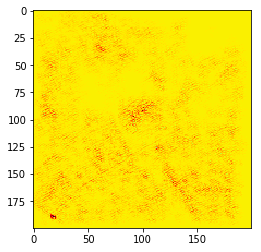

In [9]:
grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=img, 
                           backprop_modifier='guided', grad_modifier='negate')
plt.imshow(grads, cmap='jet')

Lets try all the classes and show original inputs and their heatmaps side by side. We cannot overlay the heatmap on original image since its grayscale.

We will also compare the outputs of guided and rectified or deconv saliency.

In [10]:
# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=img, backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

NameError: name 'y_test' is not defined

Guided saliency seems to give the best results.

## grad-CAM - vanilla, guided, rectified

These should contain more detail since they use `Conv` or `Pooling` features that contain more spatial detail which is lost in `Dense` layers. The only additional detail compared to saliency is the `penultimate_layer_idx`. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if `penultimate_layer_idx` is not defined, it searches for the nearest pre layer. For our architecture, that would be the `MaxPooling2D` layer after all the `Conv` layers. Lets look at all the visualizations like before.

In [ ]:
from vis.visualization import visualize_cam

# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=x_test[idx], backprop_modifier=modifier)        
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

In this case it appears that saliency is better than grad-CAM as penultimate `MaxPooling2D` layer has `(12, 12)` spatial resolution which is relatively large as compared to input of `(28, 28)`. Is is likely that the conv layer hasnt captured enough high level information and most of that is likely within `dense_4` layer. 

Here is the model summary for reference.

In [ ]:
model.summary()

## Visualization without swapping softmax

As alluded at the beginning of the tutorial, we want to compare and see what happens if we didnt swap out softmax for linear activation. Lets try this with guided saliency which gave us the best results so far.

In [ ]:
# Swap linear back with softmax
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]
    
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                               seed_input=x_test[idx], backprop_modifier='guided')

    f, ax = plt.subplots(1, 2)
    ax[0].imshow(x_test[idx][..., 0])
    ax[1].imshow(grads, cmap='jet')

It does not work as well! 

It does not work! The reason is that maximizing an output node can be done by minimizing other outputs. Softmax is weird that way. It is the only activation that depends on other node output(s) in the layer.